In [11]:
#import necessary libraries
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD, RMSprop, Adagrad, Adam
from keras.utils import np_utils
from keras.layers.core import Dropout
import matplotlib.pyplot as plt

Report by Ida Johanne Austad

# MNIST & Multilayer Perceptron - Hyperparameter tuning

This report is a response to the coursework for week 5 in Machine Learning and Statistics 2 - on Neural Networks. The aim of the report is to show understanding of what a Multilayer Perceptron is, how to build one and how the different hyperparameters affect the performance of a Multilayer Perceptron. This will be done using the MNIST dataset, where the aim is to correctly classify handwritten numbers from 0-9. <br>

The report will first give a short introduction to what a Multi-Layer Perceptron is, the purpose of hyperparameter tuning and a short introduction to Gradient Descent. Secondly, a baseline model will be created, trained and evaluated for the purpose of comparison as we go on to tweak the different hyperparameters. This baseline model is equivalent to one of the models presented in the material from class, without dropout, as this will be one of the hyperparameters investigated. After the baseline model has been created the report will investigate the effect of one hyperparameter at a time, while keeping all others the same as in the baseline model. At the end a short discussion and conclusion will summarize what has been learnt and how one would move on with further development of the network.<br>

## What is a Multilayer Perceptron and what is the purpose of hyperparameter tuning?

A Multilayer Perceptron is an Artificial Neural Network inspired by the way the brain works. It comprises of one or more hidden layers of units (aka neurons, like in the brain), in addition to the input and output layers. Between the units are directed connections with weights. By passing samples of observations through the network we allow the network to understand the particularities and commonalities of the observations, and will as such learn the "nature" (features) of what it is observing. This is done incrementally by adjusting the connection weights and biases (i.e. the networks parameters) in each iteration and in the end land on an estimated value for all these.  This can then, for instance, be used to classify different "cases" apart - such as hand written numbers in this coursework. Since there are several layers of units in MLP, it is a Deep Learning technique. <br>

Hyperparameters decide the structure of the network (e.g. number of hidden layers and number of units) and determines how the network will learn (e.g. Learning Rate, Momentum). The value which these hyperparameters take will have a great effect on the performance of the network - i.e. its ability to generalize and learn "the rules" from a training sample and apply this "knowledge" to unseen data. In this coursework we will investigate how well a MLP will be able to recognize handwritten numbers between 0 and 9, after some training, using different values of a selection of hyperparameters. <br>

The following hyperparameters will be investigated in this report:<br>

 - Number of hidden layers <br> 
 - Number of units per layer <br> 
 - Dropout <br> 
 - Learning rate <br> 
 - Momentum <br> 
 - Batch size <br> 
 - Optimization algorithm <br> 

Note I: Here, we will only do one simulation with one random seed per hyperparameter. Weight initialization is one way to tune the implementation of a neural network, but this will not be subject to investigation in this report. Several of the weight initialization alternatives provided by Keras are affected by the random seed, including the default initializer "glorot_uniform" for Dense layers which is used in this report [10, 11]. The weights direct the starting conditions for the simulation and as such the result (accuracy) be obtain for each simulation. In reality one would run the code several times with different random seeds to ensure that the obtained accuracy was not just "luck", but that the implementation has a stable performance across different starting conditions (weights) [12]. <br> 

Note II: The verbose output, showing the result of each epoch, has been left out of this report to avoid it becoming to lenghty. Still, end results such as test accuracy is of course included.

## Gradient Decent - some background

As the baseline model uses the optimizing algorithm Mini Batch Stochastic Gradient Descent and several of the hyperparameters to be tuned are passed as arguments to adjust how this optimizer works, it is valuable to give a it a short intoduction to Gradient Descent here - so that the later discussions have sufficient background and context. In short, Gradient Descent is an optimization algorithm which will move through our error space - drawn up by the errors/loss given by different combinations of the parameters (weights and bias) our network is trying to estimate - to try to find the location in this space with the lowest value; a minima - the combination of parameter values which gives the lowest error/loss. A gradient can be defined as “... how much the output of a function changes if you change the inputs a little bit.” [13], and thus a Gradient Descent algorithm uses the gradient, or slope if you want, to find which direction to move - which allows us to reduce the error/loss the most. That would be the direction with the largest negative gradient/slope. The process is often compared with climbing down a mountain into the vally, preferrably the deepest vally. There are different variations of Gradient Descent which use different amounts of the training data before the update parameters. The version used in the baseline model is Mini Batch Stochastic Gradient Descent. The sections investigating Batch Size will get further into the different versions and the meaning of batch size.

# Baseline model

## Set parameters for baseline model and prepare data

This section defines the hyperparameters to be used in the baseline model, loads and prepares the dataset (MNIST) to be investigated.

In [12]:
# setting baseline model parameters used for training 
# will be changed during the hyperparameter tuning

# number of times the entire training dataset 
#is shown to the network during training
N_EPOCH = 20 

# number of training examples in one 
#backward/forward pass (before updating weights)
BATCH_SIZE = 128 

VERBOSE = 1
N_CLASSES = 10   # number of output classes (numbers 0-9)
OPTIMIZER = SGD() # Stochastic gradient descent optimiser
N_HIDDEN = 128 # number of hidden units
VALIDATION_SPLIT= 0.2 # proportion of data used for validation

#28x28 pixels reshaped in a vector of 784 pixels
RESHAPED = 784

# random seed 
np.random.seed(222) 

Load MNIST dataset and split into training and test set.

In [14]:
# load mnist dataset and split into training and test set
(input_X_train, output_Y_train), (input_X_test, output_Y_test) 
                                        = mnist.load_data()

Reshape input data to a linear vector of 784 and normalise input data.

In [15]:
# use 60000 images for training, 10000 for validation test
input_X_train = input_X_train.reshape(60000, RESHAPED)
input_X_test = input_X_test.reshape(10000, RESHAPED)
input_X_train = input_X_train.astype('float32')
input_X_test = input_X_test.astype('float32')

# normalisation to 0-1 range 
input_X_train /= 255
input_X_test /= 255

Prepare output data by using one-hot encoding.

In [16]:
# convert class vectors to binary class matrices
output_Y_train = np_utils.to_categorical(output_Y_train, N_CLASSES)
output_Y_test = np_utils.to_categorical(output_Y_test, N_CLASSES)

## Build, train and test baseline model

We create a multi-layer perceptron equal to one introduced in class to use as baseline model for comparison with variations in hyperparameter values.

In [17]:
#create model object
model = Sequential()

# hidden layer 1 with 128 hidden units and ReLu activation function
model.add(Dense(N_HIDDEN, input_shape=(RESHAPED,)))
model.add(Activation('relu'))
# hidden layer 2 with 128 hidden units and ReLu activation function
model.add(Dense(N_HIDDEN))
model.add(Activation('relu'))

# output layer with 10 units (0-9) and softmax activation
model.add(Dense(N_CLASSES))
model.add(Activation('softmax'))

# Summary of the model
model.summary()

# compilation
model.compile(loss='categorical_crossentropy', 
              optimizer=OPTIMIZER, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
activation_4 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
activation_5 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
_________________________________________________________________
activation_6 (Activation)    (None, 10)                0         
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#train the network
history = model.fit(input_X_train, 
                    output_Y_train, batch_size=BATCH_SIZE, 
                    epochs=N_EPOCH, verbose=VERBOSE, 
                    validation_split=VALIDATION_SPLIT)

In [19]:
#test the network
score = model.evaluate(input_X_test, output_Y_test, verbose=VERBOSE)
print("\nTest score/loss:", score[0])
print("Test accuracy:", score[1])

10000/10000 [==============================] - 0s 32us/step

Test score/loss: 0.19407952138632537
Test accuracy: 0.9455


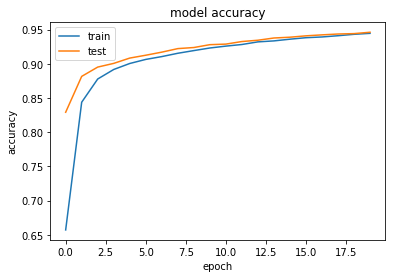

In [20]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

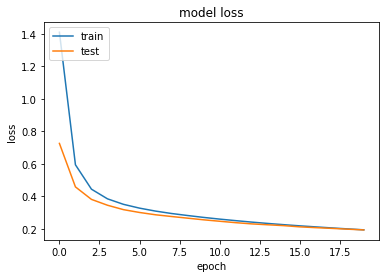

In [21]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

This is the result we want to compare with - a test loss of 0.194 and 0.9455 in test accuracy. We will through exploring the different hyperparameters below see if we can improve our model and in general learn how the different hyperparameters affect the model's performance. It is considered too extensive to create plots equivalent to the ones above for all the alternative models created in this report. Still, it is important to note that looking at these plots and training vs test performance (for obtained accuracy and loss) evolves across epochs could have been interesting in several of the cases. This could for instance affect decisions such as how many epochs to use or give other insights into the training and test process which can guide the choice of hyperparameters.

# Hyperparameter tuning

## Network size: Number of hidden layers 

Number of hidden layers is the number of layers of units in addition to the input and output layer in the network. It is said to be chosen carefully. One reason is that too many layers can result in overfitting (overtraining on the training data, and thus not being able generalize to unseen observations), while to few can result in higher bias and underfitting. Also, it is not necessary to have more layers than the complexity of the problem at hand necessitates, which would mean longer time spent on training than really required. The more complex the problem - the more layers may be desirable [1,8]. Here we will test with 3 and 4 hidden layers, as the baseline model had 2 (and we tested with 1 in the practical session).

In [ ]:
N_LAYERS = [2,3] #in addition to first hidden layer and output layer
test_score = []
test_accuracy = []    
  
for i in N_LAYERS:
    
    model = Sequential()
    
    # Hidden layer 1 which reshapes the input
    model.add(Dense(N_HIDDEN, input_shape=(RESHAPED,)))
    model.add(Activation('relu'))
    
    #loop to add i layers with ReLU activation function
    for j in range(i):
            model.add(Dense(N_HIDDEN))
            model.add(Activation('relu'))

    # output layer with 10 units and softmax activation
    model.add(Dense(N_CLASSES))
    model.add(Activation('softmax'))
    
    # compilation
    model.compile(loss='categorical_crossentropy', 
                  optimizer=OPTIMIZER, metrics=['accuracy'])
    
    history = model.fit(input_X_train, output_Y_train, 
                        batch_size=BATCH_SIZE, epochs=N_EPOCH, 
                        verbose=VERBOSE, 
                        validation_split=VALIDATION_SPLIT)

    score = model.evaluate(input_X_test, output_Y_test, 
                           verbose=VERBOSE)
    test_score.append(score[0])
    test_accuracy.append(score[1])

In [23]:
for i in range(len(N_LAYERS)):
    print("\nUsing " + str(N_LAYERS[i]+1) + " hidden layers gave:")
    print("Test score/loss", test_score[i])
    print("Test accuracy:", test_accuracy[i])


Using 3 hidden layers gave:
Test score/loss 0.1622661118760705
Test accuracy: 0.9497

Using 4 hidden layers gave:
Test score/loss 0.14527234137579798
Test accuracy: 0.9564


The results above show that the test accuracy has increased, compared to the baseline model (0.945), for each hidden layer added to the model. Out of the two results above the model with 4 hidden layers is the best, and in a real life strategy this might motivate trying even higher numbers of layers. On the other hand, adding additional layers to a model which is to solve a relatively simple problem such as MNIST, can be considered an expensive way to improve the performance due to the increased complexity of the network structure. Thus, it may be wise to investigate other hyperparameters before deciding to increase the number of layers added.

## Layer size: Number of units per hidden layer

As for the number of layers, the number of units per hidden layer has to be chosen carefully to avoid over- or underfitting. Adding more units to the layers can make the model better able to understand the features of the data, but too many can on the other hand learn "too much" about the training data, not being able to generelize to unseen data (overfitting).  As for layers, too many units can result in that it takes longer time than necessary to train the network. The more complex the problem the more units may be desirable. There are several rules which guides how many units to choose, and one rule says to choose a number between the number of input units (785 here, 784+1 bias unit) and number of output units (10 here), and this is the motivation for the values chosen below [1,8]. The value was 128 for the baseline model, and is thus not included.

In [ ]:
#define number of units to try per layer
N_HIDDEN = [64,256, 512]
test_score = []
test_accuracy = []

for i in N_HIDDEN:
    model = Sequential()

    # Hidden layer 1 with i hidden units and ReLu activation function
    model.add(Dense(i, input_shape=(RESHAPED,)))
    model.add(Activation('relu'))
    # Hidden layer 2 with i hidden units and ReLu activation function
    model.add(Dense(i))
    model.add(Activation('relu'))

    # output layer with 10 units and softmax activation
    model.add(Dense(N_CLASSES))
    model.add(Activation('softmax'))

    # compilation
    model.compile(loss='categorical_crossentropy', 
                  optimizer=OPTIMIZER, metrics=['accuracy'])
    
    #train the network
    history = model.fit(input_X_train, 
                        output_Y_train, 
                        batch_size=BATCH_SIZE, 
                        epochs=N_EPOCH, 
                        verbose=VERBOSE, 
                        validation_split=VALIDATION_SPLIT)

    score = model.evaluate(input_X_test, 
                           output_Y_test, verbose=VERBOSE)

    test_score.append(score[0])
    test_accuracy.append(score[1])

In [25]:
for i in range(len(N_HIDDEN)):
    print("\nUsing " + str(N_HIDDEN[i]) + " units gave:")
    print("Test score/loss", test_score[i])
    print("Test accuracy:", test_accuracy[i])


Using 64 units gave:
Test score/loss 0.2006501191586256
Test accuracy: 0.9414

Using 256 units gave:
Test score/loss 0.18610936435237527
Test accuracy: 0.945

Using 512 units gave:
Test score/loss 0.17023214867115022
Test accuracy: 0.9519


Above we can see that one of the models we just trained performed better that our baseline model (0.9455). The model with 512 units per hidden layer, versus 128 in the baseline, gives a better test accuracy. This is as expected as adding more units to the layers was explained in this section's introduction to potentially improve the model's ability to understand the features in the data. As for adding more hidden layers, adding more units to hidden layers may slow down the training of the model and potentially make it unnessecarily complex. Thus, it must be investigated in conjunction with tuning of other parameters. Still, one could have added a few more options in this section - more units per layer - to see if the test accuracy started to decrease again at some point (indicating potential overfitting due to too many units per layer).

## Dropout

Dropout means that we randomly drop a specified proportion of the units from each layer in each training iteration and in effect end up with a simpler network (only during training, as dropout is not applied in test). It is a method to prevent the model from overfitting. It has the effect of making the training process more noisy and forces the units within a layer to be more attentive as gets "less" learning opportunities and cannot depend on all the other units in it's layer in each iteration. It is said that the units learn more "robust" features using dropout. Altough dropout often necessitates more iterations, it takes less time per epoch [3].

In [ ]:
#reset the number of hidden units to be the same as in the baseline
N_HIDDEN = 128

#create vector to hold the dropout percentages we want to try
P_DROPOUT = [0.1, 0.2, 0.3, 0.4, 0.5]
test_score = []
test_accuracy = []

for i in P_DROPOUT:
    model = Sequential()

    # Hidden layer 1 with 128 hidden units and ReLu activation function
    model.add(Dense(N_HIDDEN, input_shape=(RESHAPED,)))
    model.add(Activation('relu'))
    model.add(Dropout(i))

    # Hidden layer 2 with 128 hidden units and ReLu activation function
    model.add(Dense(N_HIDDEN))
    model.add(Activation('relu'))
    model.add(Dropout(i))

    # output layer with 10 units and softmax activation
    model.add(Dense(N_CLASSES))
    model.add(Activation('softmax'))

    # compilation
    model.compile(loss='categorical_crossentropy', 
                  optimizer=OPTIMIZER, metrics=['accuracy'])
    
    #train the network
    history = model.fit(input_X_train, output_Y_train, 
                        batch_size=BATCH_SIZE, epochs=N_EPOCH, 
                        verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

    score = model.evaluate(input_X_test, 
                           output_Y_test, verbose=VERBOSE)
    
    test_score.append(score[0])
    test_accuracy.append(score[1])

In [27]:
for i in range(len(P_DROPOUT)):
    print("\nUsing dropout rate " + str(P_DROPOUT[i]) + " gave:")
    print("Test score/loss", test_score[i])
    print("Test accuracy:", test_accuracy[i])


Using dropout rate 0.1 gave:
Test score/loss 0.18116655552238226
Test accuracy: 0.9479

Using dropout rate 0.2 gave:
Test score/loss 0.1852808731086552
Test accuracy: 0.9454

Using dropout rate 0.3 gave:
Test score/loss 0.19091025214716792
Test accuracy: 0.9426

Using dropout rate 0.4 gave:
Test score/loss 0.20369335896596313
Test accuracy: 0.9408

Using dropout rate 0.5 gave:
Test score/loss 0.21960563701242208
Test accuracy: 0.9346


 From the results above we see that one of the dropout options, with dropout at 0.1, performed better than our baseline model (0.9455). This can be because we have chosen to drop our rather large proportion of the units - up to 0.5. Still, we can see that the accuracy remains above 0.93 for all options - while the training took less time due to the reduced number of units involved in each iteration. If one where to investigate this further one could see if any values around 0.1 gave an even better accuracy, but for the purpose of this courswork this result is considered sufficient. 

## Learning rate

The learning rate is the hyperparameter which controls how much we will adjust the weights after each iteration. The lower the value of the learning rate the slower we will move along the error surface towards a minima (can be global or local) - as we take "smaller steps", while larger value allows us to take larger steps. While a small learning rate will converge slowly towards the minima, and will as such be less likely to jump past or miss the slope down to a minima, it can take too much time. A learning rate which is too high can make us miss the minima as we "jump" past it and can potentially not converge. A low learning rate can also get us stuck in a plateau, if a region in the error surface is flat [4]. The default value used by Keras' SDG is 0.01, so we shall try a few alternatives [7].

In [ ]:
#specify vector of learning rates we will test
LEARN_R = [0.001, 0.1,0.2, 0.3, 0.5, 0.6]
test_score = []
test_accuracy = []

for i in LEARN_R:
    model = Sequential()

    # Hidden layer 1 with 128 hidden units and ReLu activation function
    model.add(Dense(N_HIDDEN, input_shape=(RESHAPED,)))
    model.add(Activation('relu'))
    # Hidden layer 2 with 128 hidden units and ReLu activation function
    model.add(Dense(N_HIDDEN))
    model.add(Activation('relu'))

    # output layer with 10 units and softmax activation
    model.add(Dense(N_CLASSES))
    model.add(Activation('softmax'))

    #for each loop we want to use a new value for the learning rate
    OPTIMIZER = SGD(lr = i)    

    # compilation
    model.compile(loss='categorical_crossentropy', 
                  optimizer=OPTIMIZER, metrics=['accuracy'])
    
    #train the network
    history = model.fit(input_X_train, output_Y_train, 
                        batch_size=BATCH_SIZE, epochs=N_EPOCH, 
                        verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

    #get the score and store them to print after finish
    score = model.evaluate(input_X_test, output_Y_test, verbose=VERBOSE)
    test_score.append(score[0])
    test_accuracy.append(score[1])

In [29]:
for i in range(len(LEARN_R)):
    print("\nUsing learning rate " + str(LEARN_R[i]) + " gave:")
    print("Test score/loss", test_score[i])
    print("Test accuracy:", test_accuracy[i])


Using learning rate 0.001 gave:
Test score/loss 0.4671427490711212
Test accuracy: 0.8762

Using learning rate 0.1 gave:
Test score/loss 0.08377402248502476
Test accuracy: 0.9742

Using learning rate 0.2 gave:
Test score/loss 0.0771518416537554
Test accuracy: 0.9801

Using learning rate 0.3 gave:
Test score/loss 0.08348359558877837
Test accuracy: 0.9794

Using learning rate 0.5 gave:
Test score/loss 0.09487410609824964
Test accuracy: 0.9803

Using learning rate 0.6 gave:
Test score/loss 0.09507778749285883
Test accuracy: 0.9806


By the reults above we can see that all variations of learning rate except 0.001 (the only one lower than the learning rate used in our baseline model) managed to get a better test accuracy than 0.9455. The best results are given by the model using a learning rate of 0.6 - with an accuracy of 0.9806. As such we can see how important the potential of tuning the learning rate is, and that we in a real scenario could have been interested in investigating the results of using learning rates higher and/or around 0.6 - for further improvement. Still, setting it too high comes with risks - as discussed before. That is where the hyperparameter Momentum can help us.

## Momentum

Momentum takes values from 0 to 1 and directs how much we should let our previous weight updates affect the current weight update. Choosing a good momentum can thus help us reduce the risks we discussed related to choosing a too low/too high learning rate (too small - too slow training, too large - passes the minima and the potential of never converging). Momentum has the effect of adapting the learning rate to the "territory" that we are experiencing in the error space. It speeds up the training by allowing to move faster (larger updates to weights) in the beginning and/or when the slope is steep, but as the slope changes direction it will reduce the weight updates and thus make it less likely that one will miss a minima and more likely to converge [9]. The default value used in Keras SGD is 0.0, thus a few other values will be tried [7].

In [ ]:
#specify vector of momentums we want to test out
MOMENTUM = [0.2, 0.4,0.6, 0.8]
test_score = []
test_accuracy = []

for i in MOMENTUM:
    model = Sequential()

    # Hidden layer 1 with 128 hidden units and ReLu activation function
    model.add(Dense(N_HIDDEN, input_shape=(RESHAPED,)))
    model.add(Activation('relu'))
    # Hidden layer 2 with 128 hidden units and ReLu activation function
    model.add(Dense(N_HIDDEN))
    model.add(Activation('relu'))

    # output layer with 10 units and softmax activation
    model.add(Dense(N_CLASSES))
    model.add(Activation('softmax'))

    #for each loop we want to use a new value for the momentum
    OPTIMIZER = SGD(momentum = i)    

    # compilation
    model.compile(loss='categorical_crossentropy', 
                  optimizer=OPTIMIZER, metrics=['accuracy'])
    
    #train the network
    history = model.fit(input_X_train, output_Y_train, 
                        batch_size=BATCH_SIZE, 
                        epochs=N_EPOCH, verbose=VERBOSE, 
                        validation_split=VALIDATION_SPLIT)

    #get the score and store them to print after finish
    score = model.evaluate(input_X_test, output_Y_test, verbose=VERBOSE)
    test_score.append(score[0])
    test_accuracy.append(score[1])

In [31]:
for i in range(len(MOMENTUM)):
    print("\nUsing Momentum " + str(MOMENTUM[i]) + " gave:")
    print("Test score/loss", test_score[i])
    print("Test accuracy:", test_accuracy[i])


Using Momentum 0.2 gave:
Test score/loss 0.16845399807095526
Test accuracy: 0.9507

Using Momentum 0.4 gave:
Test score/loss 0.1414313634209335
Test accuracy: 0.9573

Using Momentum 0.6 gave:
Test score/loss 0.11963009840995073
Test accuracy: 0.9643

Using Momentum 0.8 gave:
Test score/loss 0.08930754054784774
Test accuracy: 0.9742


From the result above we can see that all the variations of momentum performs better than our baseline (0.9455). The best result is given with a momentum of 0.8, with a test accuracy of 0.9742. 

## Batch size

Batch size is a hyperparameter (when using the Gradient Descent optimization algorithm) which specifies the number of samples shown to the network before parameters are updated. In our baseline model and the previous variations we used Stochastic Gradient Descent (SDG), with a batch size of 128, as our optimizer. The default batch size with SDG is 1. That is, we show the network 1 sample before it updates its parameter value. If one were to define a batch as the entire training dataset, the optimizing method is called Batch Gradient Descent [5]. Smaller batch sizes has the effect that it presents the network with more noise and as such can allow the network to become better at generalization - and thus reduce likelihood overfitting. Also, smaller batch sizes are easier to fit into memory when using a GPU, and can as such speed up the training [6]. <br>

In this section we will see what happens when we change the batch size to values: 1 < Batch Size < size of entire training set. This version of Gradient Descent is known as Mini-Batch Gradient Descent, and has been used in the previous models as well. Here we test with batch sizes which are suggested by practicians, excluding the one used in the baseline model (=128) [6].

In [ ]:
#reset optimiser to the same as the baseline
OPTIMIZER = SGD()

#define a vector of batch sizes to test
BATCH_SIZE = [32,64,256, 512]
test_score = []
test_accuracy = []

for i in BATCH_SIZE:
    model = Sequential()

    # Hidden layer 1 with 128 hidden units and ReLu activation function
    model.add(Dense(N_HIDDEN, input_shape=(RESHAPED,)))
    model.add(Activation('relu'))
    # Hidden layer 2 with 128 hidden units and ReLu activation function
    model.add(Dense(N_HIDDEN))
    model.add(Activation('relu'))

    # output layer with 10 units and softmax activation
    model.add(Dense(N_CLASSES))
    model.add(Activation('softmax'))

    # compilation
    model.compile(loss='categorical_crossentropy', 
                  optimizer=OPTIMIZER, metrics=['accuracy'])

    #train the network
    history = model.fit(input_X_train, output_Y_train, 
                        batch_size=i, epochs=N_EPOCH, 
                        verbose=VERBOSE, 
                        validation_split=VALIDATION_SPLIT)

    score = model.evaluate(input_X_test, output_Y_test, 
                           verbose=VERBOSE)

    test_score.append(score[0])
    test_accuracy.append(score[1])

In [33]:
for i in range(len(BATCH_SIZE)):
    print("\nUsing Batch Size " + str(BATCH_SIZE[i]) + " gave:")
    print("Test score/loss", test_score[i])
    print("Test accuracy:", test_accuracy[i])


Using Batch Size 32 gave:
Test score/loss 0.09763096881974488
Test accuracy: 0.9711

Using Batch Size 64 gave:
Test score/loss 0.13461268049366773
Test accuracy: 0.9585

Using Batch Size 256 gave:
Test score/loss 0.2559405641555786
Test accuracy: 0.9278

Using Batch Size 512 gave:
Test score/loss 0.3147944088339806
Test accuracy: 0.9121


From the above results we can se that the two options which specify batch size smaller than the baseline model, also gives better results. The best test accuracy is given by using batch size of 32 with a test accuracy of 0.9711. This is in line with practitioners statments saying that batch sizes of 32 and lower has shown to perform the best [6]. As such, one could have been interested in testing even lower batch sizes to see the effect on the model's performance.

## Optimization algorithm

In the setting of Neural Networks, as described in the introduction to Gradient Descent as an example, the optimization algorithm helps us to minimze of our objective function - which is the loss/error in the training process, and thus maximise the training accuracy. There are different ways of navigating the error space, which has thus come to be different optimization algorithms. We have already seen two adjustments which can be made to SDG - namely the size of our steps in the error space (learning rate) and how much we take into account previous steps (momentum). These where both parameters passed to the optimizer used in the baseline model - (Mini Batch) Stochastic Gradient Descent. <br> 

Here we will test three alternative optimization algorithms and evaluate their performance. All try to handle the potential risks and issues faced by Gradient Descent, as mentioned earlier; potential of slow convergence with lowe learning rate, potential of missing minimia or diverging in case of large learning rate, issues with finding minima in highly non-convex error spaces (many local minimas) and potental of getting trapped in flat regions (saddle points). We already looked at the hyperparameter Momentum, which helped mitigate these risks, and which has thus been integrated into these algorithms. However, one challenge with Momentum is that is does not necessarialy slow down the weight updates as it gets close to the minima - if its speed (and as such size of weight updates) is too large. Thus, one can still miss a minima when using momentum [14]. <br> 

 - Adagrad: This optimization algorithm allows the learning rate to adapt based on the parameters. For parameters which are updated often, the learning rate will be smaller. For parameters which are updated more seldom it will make larger updates. As such it takes all previous updates (gradients) of each parameter into account and allows for an adaptive learning rate. This has the benefit that one does not have to specify a specific learning rate, and the learning rate will adapt automtically - as when specifying a momentum [14]. A disadvantage with using Adagrad is that it faces a decaying learning rate. Due the fact that it takes all past gradients equally into account when estimating the learning rate per parameter - the learning rate will eventually become very small, and the model will not learn anymore. The result is that convergence and thus training can take too much time. <br>

 - ADAM: Adaptive Moment Estimation (ADAM) also uses adaptive learning rates for each parameter. But, by computing the learning rates for the parameters from both the first and second moments of the previous gradients it obtain even better results, and avoids the issue with decreasing learning rate. Using ADAM, both the means of the previous moments and the uncentered variance of the previous moments are taken into account when adapting the parameters' learning rates [15]. 

In [ ]:
#reset batch size to same as baseline
BATCH_SIZE = 128

#define vector with optimization algorithms to try
OPTIMIZER = ["Adagrad", "Adam"]
test_score = []
test_accuracy = []

for i in OPTIMIZER:
    model = Sequential()

    # Hidden layer 1 with 128 hidden units and ReLu activation function
    model.add(Dense(N_HIDDEN, input_shape=(RESHAPED,)))
    model.add(Activation('relu'))
    # Hidden layer 2 with 128 hidden units and ReLu activation function
    model.add(Dense(N_HIDDEN))
    model.add(Activation('relu'))

    # output layer with 10 units and softmax activation
    model.add(Dense(N_CLASSES))
    model.add(Activation('softmax'))
    
    # compilation with optimization algorithm i
    model.compile(loss='categorical_crossentropy', optimizer=i, 
                  metrics=['accuracy'])
    
    #train the network
    history = model.fit(input_X_train, output_Y_train, 
                        batch_size=BATCH_SIZE, epochs=N_EPOCH, 
                        verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

    #get the score and store them to print after finish
    score = model.evaluate(input_X_test, output_Y_test, verbose=VERBOSE)
    test_score.append(score[0])
    test_accuracy.append(score[1])

In [35]:
for i in range(len(OPTIMIZER)):
    print("\nUsing Optimizer " + str(OPTIMIZER[i]) + " gave:")
    print("Test score/loss", test_score[i])
    print("Test accuracy:", test_accuracy[i])


Using Optimizer Adagrad gave:
Test score/loss 0.07125321100392612
Test accuracy: 0.9769

Using Optimizer Adam gave:
Test score/loss 0.09775170024595554
Test accuracy: 0.9785


# Summary

Results summarized - test accuracy: <br>

 - Baseline model: 0.9455 <br>
 - 4 hidden layers: 0.9564 <br>
 - 512 units per hidden layer: 0.9519 <br>
 - Dropout proportion 0.1: 0.9479 <br>
 - Learning rate 0.6: 0.9806 <br>
 - Momentum 0.8: 0.9742 <br>
 - Batch size 32: 0.9711 <br>
 - ADAM: 0.9785 <br>

All in all, we see that it was the adjustment of the hyperparameter learning rate to 0.6 which gave the highest test accuracy and thus the largest improvement compared to the baseline model. However, we have investigated and learned how all the different hyperparameters affect how a Neural Network model can perform, and that they can all have their contributions and play a role. Moreover, it is important to mention that one would usually tune the hyperparameters together - looking for the best combinations of hyperparameters.  This is because the hyperparameters can affect each other, and should as such be investigated together. Thus, saying that we would move forward with a combination of the hyperparameters presented in this list would not be advisable - one should see how they perform together - with different values. Lastly, one must take the problem at hand into account when making these decisions and take into account additional considerations  - not just test accuracy, such as time needed for training, type and characteristics of data and problem etc. 

# Sources: 

1. What are hyperparameters? And how to tune the Hyperparameters in a Deep Neural Network? https://towardsdatascience.com/what-are-hyperparameters-and-how-to-tune-the-hyperparameters-in-a-deep-neural-network-d0604917584a <br>
2. Improving Neural Networks – Hyperparameter Tuning, Regularization, and More  https://www.analyticsvidhya.com/blog/2018/11/neural-networks-hyperparameter-tuning-regularization-deeplearning/ <br>
3. A Gentle Introduction to Dropout for Regularizing Deep Neural Networks https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/ <br>
4. Understanding Learning Rates and How It Improves Performance in Deep Learning https://towardsdatascience.com/understanding-learning-rates-and-how-it-improves-performance-in-deep-learning-d0d4059c1c10 <br>
5. What is the Difference Between a Batch and an Epoch in a Neural Network? https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/ <br>
6. How to Control the Speed and Stability of Training Neural Networks With Gradient Descent Batch Size https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/ <br> 
7. Keras Documentation - Optimizers https://keras.io/optimizers/ <br>
8. How to choose the number of hidden layers and nodes in a feedforward neural network? https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
9. Neural Network Momentum https://jamesmccaffrey.wordpress.com/2017/06/06/neural-network-momentum/
10. Keras Documentation - Initializers https://keras.io/initializers/
11. Keras Documentation - Core Layers https://keras.io/layers/core/
12. Where do 'random seeds' get used in deep neural networks? https://ai.stackexchange.com/questions/6240/where-do-random-seeds-get-used-in-deep-neural-networks
13. Gradient Descent in a Nutshell https://towardsdatascience.com/gradient-descent-in-a-nutshell-eaf8c18212f0
14. Types of Optimization Algorithms used in Neural Networks and Ways to Optimize Gradient Descent https://towardsdatascience.com/types-of-optimization-algorithms-used-in-neural-networks-and-ways-to-optimize-gradient-95ae5d39529f
15. Gentle Introduction to the Adam Optimization Algorithm for Deep Learning https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/